In [15]:
#!/usr/bin/env python3
"""
Employee Turnover Analytics - Course-end Project 3
Portobello Tech HR Department ML Analysis
This script performs comprehensive analysis of employee turnover data including:
1. Data quality checks
2. Exploratory Data Analysis (EDA)
3. Clustering of employees who left
4. SMOTE for class imbalance handling
5. K-fold cross-validation model training
6. Model performance evaluation
7. Retention strategy recommendations
"""

'\nEmployee Turnover Analytics - Course-end Project 3\nPortobello Tech HR Department ML Analysis\nThis script performs comprehensive analysis of employee turnover data including:\n1. Data quality checks\n2. Exploratory Data Analysis (EDA)\n3. Clustering of employees who left\n4. SMOTE for class imbalance handling\n5. K-fold cross-validation model training\n6. Model performance evaluation\n7. Retention strategy recommendations\n'

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations

In [17]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [18]:
class EmployeeTurnoverAnalysis:
    def __init__(self, data_path):
        """Initialize the analysis with the dataset path."""
        self.data_path = data_path
        self.df = None
        self.df_encoded = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}

    def load_data(self):
        """Load the dataset and perform initial exploration."""
        print("=" * 60)
        print("EMPLOYEE TURNOVER ANALYTICS")
        print("=" * 60)

        # Load the dataset
        self.df = pd.read_csv(self.data_path)
        print(f"Dataset loaded successfully!")
        print(f"Shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")

        return self.df

    def data_quality_check(self):
        """Perform comprehensive data quality checks."""
        print("\n" + "=" * 60)
        print("DATA QUALITY CHECKS")
        print("=" * 60)

        # Check for missing values
        print("\n1. Missing Values Check:")
        missing_values = self.df.isnull().sum()
        if missing_values.sum() == 0:
            print("✓ No missing values found in the dataset")
        else:
            print("✗ Missing values found:")
            print(missing_values[missing_values > 0])

        # Check data types
        print("\n2. Data Types:")
        print(self.df.dtypes)

        # Check for duplicates
        print(f"\n3. Duplicate Rows: {self.df.duplicated().sum()}")

        # Basic statistics
        print("\n4. Basic Statistics:")
        print(self.df.describe())

        # Check target variable distribution
        print(f"\n5. Target Variable Distribution (left):")
        print(self.df['left'].value_counts())
        print(f"Turnover Rate: {self.df['left'].mean():.2%}")

        return self.df

    def exploratory_data_analysis(self):
        """Perform comprehensive Exploratory Data Analysis."""
        print("\n" + "=" * 60)
        print("EXPLORATORY DATA ANALYSIS")
        print("=" * 60)

        # Create figure for EDA plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Employee Turnover Analysis - Key Factors', fontsize=16, fontweight='bold')

        # 1. Satisfaction Level vs Turnover
        sns.boxplot(data=self.df, x='left', y='satisfaction_level', ax=axes[0,0])
        axes[0,0].set_title('Satisfaction Level vs Turnover')
        axes[0,0].set_xlabel('Left Company (0=No, 1=Yes)')
        axes[0,0].set_ylabel('Satisfaction Level')

        # 2. Last Evaluation vs Turnover
        sns.boxplot(data=self.df, x='left', y='last_evaluation', ax=axes[0,1])
        axes[0,1].set_title('Last Evaluation vs Turnover')
        axes[0,1].set_xlabel('Left Company (0=No, 1=Yes)')
        axes[0,1].set_ylabel('Last Evaluation')

        # 3. Number of Projects vs Turnover
        sns.boxplot(data=self.df, x='left', y='number_project', ax=axes[0,2])
        axes[0,2].set_title('Number of Projects vs Turnover')
        axes[0,2].set_xlabel('Left Company (0=No, 1=Yes)')
        axes[0,2].set_ylabel('Number of Projects')

        # 4. Average Monthly Hours vs Turnover
        sns.boxplot(data=self.df, x='left', y='average_montly_hours', ax=axes[1,0])
        axes[1,0].set_title('Average Monthly Hours vs Turnover')
        axes[1,0].set_xlabel('Left Company (0=No, 1=Yes)')
        axes[1,0].set_ylabel('Average Monthly Hours')

        # 5. Time Spent in Company vs Turnover
        sns.boxplot(data=self.df, x='left', y='time_spend_company', ax=axes[1,1])
        axes[1,1].set_title('Time Spent in Company vs Turnover')
        axes[1,1].set_xlabel('Left Company (0=No, 1=Yes)')
        axes[1,1].set_ylabel('Time Spent in Company (Years)')

        # 6. Salary Distribution by Turnover
        salary_turnover = pd.crosstab(self.df['salary'], self.df['left'], normalize='index') * 100
        salary_turnover.plot(kind='bar', ax=axes[1,2])
        axes[1,2].set_title('Turnover Rate by Salary Level')
        axes[1,2].set_xlabel('Salary Level')
        axes[1,2].set_ylabel('Percentage')
        axes[1,2].legend(['Stayed', 'Left'])

        plt.tight_layout()
        plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Correlation analysis
        print("\n6. Correlation Analysis:")
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        correlation_matrix = self.df[numeric_cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5)
        plt.title('Correlation Matrix of Numeric Features')
        plt.tight_layout()
        plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Feature importance analysis
        print("\n7. Key Insights from EDA:")
        print("-" * 40)

        # Satisfaction level analysis
        avg_satisfaction_left = self.df[self.df['left'] == 1]['satisfaction_level'].mean()
        avg_satisfaction_stayed = self.df[self.df['left'] == 0]['satisfaction_level'].mean()
        print(f"Average satisfaction level for employees who left: {avg_satisfaction_left:.3f}")
        print(f"Average satisfaction level for employees who stayed: {avg_satisfaction_stayed:.3f}")

        # Work hours analysis
        avg_hours_left = self.df[self.df['left'] == 1]['average_montly_hours'].mean()
        avg_hours_stayed = self.df[self.df['left'] == 0]['average_montly_hours'].mean()
        print(f"Average monthly hours for employees who left: {avg_hours_left:.1f}")
        print(f"Average monthly hours for employees who stayed: {avg_hours_stayed:.1f}")

        # Department analysis
        dept_turnover = self.df.groupby('sales')['left'].mean().sort_values(ascending=False)
        print(f"\nTurnover rate by department:")
        for dept, rate in dept_turnover.items():
            print(f"  {dept}: {rate:.2%}")

        return self.df

    def clustering_analysis(self):
        """Perform clustering analysis on employees who left."""
        print("\n" + "=" * 60)
        print("CLUSTERING ANALYSIS - EMPLOYEES WHO LEFT")
        print("=" * 60)

        # Filter employees who left
        employees_left = self.df[self.df['left'] == 1].copy()
        print(f"Number of employees who left: {len(employees_left)}")

        # Select features for clustering
        clustering_features = ['satisfaction_level', 'last_evaluation', 'number_project',
                             'average_montly_hours', 'time_spend_company']

        X_cluster = employees_left[clustering_features]

        # Standardize features
        X_cluster_scaled = self.scaler.fit_transform(X_cluster)

        # Determine optimal number of clusters using elbow method
        inertias = []
        K_range = range(1, 11)

        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_cluster_scaled)
            inertias.append(kmeans.inertia_)

        # Plot elbow curve
        plt.figure(figsize=(10, 6))
        plt.plot(K_range, inertias, 'bo-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        plt.savefig('elbow_curve.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Based on elbow curve, choose k=3
        optimal_k = 3
        print(f"Optimal number of clusters: {optimal_k}")

        # Perform K-means clustering
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        employees_left['cluster'] = kmeans.fit_predict(X_cluster_scaled)

        # Analyze clusters
        print("\nCluster Analysis:")
        print("-" * 40)

        cluster_analysis = employees_left.groupby('cluster')[clustering_features].mean()
        print(cluster_analysis)

        # Visualize clusters using PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_cluster_scaled)

        plt.figure(figsize=(12, 8))

        # Plot clusters
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=employees_left['cluster'],
                            cmap='viridis', alpha=0.7, s=50)
        plt.colorbar(scatter)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('Employee Clusters (PCA Visualization)')
        plt.grid(True, alpha=0.3)
        plt.savefig('employee_clusters.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Cluster profiles
        print("\nCluster Profiles:")
        print("-" * 40)

        for cluster_id in range(optimal_k):
            cluster_data = employees_left[employees_left['cluster'] == cluster_id]
            print(f"\nCluster {cluster_id} ({len(cluster_data)} employees):")
            print(f"  Average satisfaction: {cluster_data['satisfaction_level'].mean():.3f}")
            print(f"  Average evaluation: {cluster_data['last_evaluation'].mean():.3f}")
            print(f"  Average projects: {cluster_data['number_project'].mean():.1f}")
            print(f"  Average hours: {cluster_data['average_montly_hours'].mean():.1f}")
            print(f"  Average tenure: {cluster_data['time_spend_company'].mean():.1f} years")

        return employees_left

    def prepare_data_for_modeling(self):
        """Prepare data for machine learning models."""
        print("\n" + "=" * 60)
        print("DATA PREPARATION FOR MODELING")
        print("=" * 60)

        # Create a copy for encoding
        self.df_encoded = self.df.copy()

        # Encode categorical variables
        le_sales = LabelEncoder()
        le_salary = LabelEncoder()

        self.df_encoded['sales_encoded'] = le_sales.fit_transform(self.df_encoded['sales'])
        self.df_encoded['salary_encoded'] = le_salary.fit_transform(self.df_encoded['salary'])

        # Select features for modeling
        feature_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
                          'average_montly_hours', 'time_spend_company', 'Work_accident',
                          'promotion_last_5years', 'sales_encoded', 'salary_encoded']

        self.X = self.df_encoded[feature_columns]
        self.y = self.df_encoded['left']

        print(f"Features shape: {self.X.shape}")
        print(f"Target shape: {self.y.shape}")
        print(f"Class distribution: {self.y.value_counts().to_dict()}")

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )

        print(f"Training set shape: {self.X_train.shape}")
        print(f"Test set shape: {self.X_test.shape}")

        return self.X_train, self.X_test, self.y_train, self.y_test

    def handle_class_imbalance(self):
        """Handle class imbalance using SMOTE."""
        print("\n" + "=" * 60)
        print("HANDLING CLASS IMBALANCE WITH SMOTE")
        print("=" * 60)

        # Apply SMOTE to training data
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(self.X_train, self.y_train)

        print(f"Original training set class distribution:")
        print(self.y_train.value_counts())

        print(f"\nBalanced training set class distribution:")
        print(pd.Series(y_train_balanced).value_counts())

        # Update training data
        self.X_train = X_train_balanced
        self.y_train = y_train_balanced

        return self.X_train, self.y_train

    def train_models(self):
        """Train multiple models with k-fold cross-validation."""
        print("\n" + "=" * 60)
        print("MODEL TRAINING WITH K-FOLD CROSS-VALIDATION")
        print("=" * 60)

        # Initialize models
        self.models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'SVM': SVC(random_state=42, probability=True)
        }

        # K-fold cross-validation
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)

        print("Performing 5-fold cross-validation...")
        print("-" * 50)

        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            # Perform cross-validation
            cv_scores = cross_val_score(model, self.X_train, self.y_train,
                                      cv=kfold, scoring='accuracy')

            print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

            # Train on full training set
            model.fit(self.X_train, self.y_train)

            # Make predictions on test set
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1] if hasattr(model, 'predict_proba') else None

            # Calculate metrics
            self.results[name] = {
                'accuracy': accuracy_score(self.y_test, y_pred),
                'precision': precision_score(self.y_test, y_pred),
                'recall': recall_score(self.y_test, y_pred),
                'f1': f1_score(self.y_test, y_pred),
                'roc_auc': roc_auc_score(self.y_test, y_pred_proba) if y_pred_proba is not None else None,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std()
            }

        return self.models, self.results

    def evaluate_models(self):
        """Evaluate and compare model performance."""
        print("\n" + "=" * 60)
        print("MODEL EVALUATION AND COMPARISON")
        print("=" * 60)

        # Create results DataFrame
        results_df = pd.DataFrame(self.results).T
        print("\nModel Performance Comparison:")
        print(results_df.round(4))

        # Visualize model comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

        # Accuracy comparison
        axes[0,0].bar(results_df.index, results_df['accuracy'])
        axes[0,0].set_title('Accuracy Comparison')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].tick_params(axis='x', rotation=45)

        # Precision comparison
        axes[0,1].bar(results_df.index, results_df['precision'])
        axes[0,1].set_title('Precision Comparison')
        axes[0,1].set_ylabel('Precision')
        axes[0,1].tick_params(axis='x', rotation=45)

        # Recall comparison
        axes[1,0].bar(results_df.index, results_df['recall'])
        axes[1,0].set_title('Recall Comparison')
        axes[1,0].set_ylabel('Recall')
        axes[1,0].tick_params(axis='x', rotation=45)

        # F1-Score comparison
        axes[1,1].bar(results_df.index, results_df['f1'])
        axes[1,1].set_title('F1-Score Comparison')
        axes[1,1].set_ylabel('F1-Score')
        axes[1,1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Find best model
        best_model_name = results_df['f1'].idxmax()
        best_model = self.models[best_model_name]

        print(f"\nBest Model: {best_model_name}")
        print(f"F1-Score: {results_df.loc[best_model_name, 'f1']:.4f}")
        print(f"Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")
        print(f"Precision: {results_df.loc[best_model_name, 'precision']:.4f}")
        print(f"Recall: {results_df.loc[best_model_name, 'recall']:.4f}")

        # Detailed analysis of best model
        print(f"\nDetailed Analysis of {best_model_name}:")
        print("-" * 40)

        y_pred_best = best_model.predict(self.X_test)
        y_pred_proba_best = best_model.predict_proba(self.X_test)[:, 1]

        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred_best))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred_best)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Stayed', 'Left'],
                   yticklabels=['Stayed', 'Left'])
        plt.title(f'Confusion Matrix - {best_model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Feature importance (for tree-based models)
        if hasattr(best_model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': self.X.columns,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(10, 6))
            sns.barplot(data=feature_importance, x='importance', y='feature')
            plt.title(f'Feature Importance - {best_model_name}')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()

            print("\nTop 5 Most Important Features:")
            print(feature_importance.head())

        return best_model_name, best_model

    def suggest_retention_strategies(self):
        """Suggest retention strategies based on analysis."""
        print("\n" + "=" * 60)
        print("RETENTION STRATEGY RECOMMENDATIONS")
        print("=" * 60)

        # Analyze high-risk employees
        high_risk_employees = self.df[
            (self.df['satisfaction_level'] < 0.5) &
            (self.df['average_montly_hours'] > 200) &
            (self.df['left'] == 0)  # Current employees
        ]

        print(f"Number of high-risk current employees: {len(high_risk_employees)}")

        # Strategy recommendations based on analysis
        strategies = {
            "Low Satisfaction Employees": {
                "description": "Employees with satisfaction level < 0.5",
                "count": len(self.df[(self.df['satisfaction_level'] < 0.5) & (self.df['left'] == 0)]),
                "strategies": [
                    "Conduct regular employee satisfaction surveys",
                    "Implement flexible work arrangements",
                    "Provide career development opportunities",
                    "Improve work-life balance policies",
                    "Enhance recognition and reward programs"
                ]
            },
            "Overworked Employees": {
                "description": "Employees working > 250 hours/month",
                "count": len(self.df[(self.df['average_montly_hours'] > 250) & (self.df['left'] == 0)]),
                "strategies": [
                    "Implement workload management systems",
                    "Hire additional staff to reduce workload",
                    "Provide overtime compensation",
                    "Set realistic project deadlines",
                    "Encourage time-off utilization"
                ]
            },
            "Long-tenured Employees": {
                "description": "Employees with > 5 years tenure",
                "count": len(self.df[(self.df['time_spend_company'] > 5) & (self.df['left'] == 0)]),
                "strategies": [
                    "Provide career advancement opportunities",
                    "Implement mentorship programs",
                    "Offer specialized training and certifications",
                    "Create leadership development programs",
                    "Provide competitive compensation packages"
                ]
            },
            "High Performers": {
                "description": "Employees with evaluation > 0.8",
                "count": len(self.df[(self.df['last_evaluation'] > 0.8) & (self.df['left'] == 0)]),
                "strategies": [
                    "Implement performance-based bonuses",
                    "Provide challenging projects",
                    "Offer leadership opportunities",
                    "Create fast-track promotion programs",
                    "Provide competitive market compensation"
                ]
            },
            "Low Salary Employees": {
                "description": "Employees with low salary level",
                "count": len(self.df[(self.df['salary'] == 'low') & (self.df['left'] == 0)]),
                "strategies": [
                    "Conduct salary benchmarking studies",
                    "Implement performance-based raises",
                    "Provide additional benefits and perks",
                    "Create profit-sharing programs",
                    "Offer equity or stock options"
                ]
            }
        }

        print("\nTargeted Retention Strategies:")
        print("-" * 50)

        for category, details in strategies.items():
            print(f"\n{category}:")
            print(f"  Target Group: {details['description']}")
            print(f"  Number of Employees: {details['count']}")
            print(f"  Recommended Strategies:")
            for i, strategy in enumerate(details['strategies'], 1):
                print(f"    {i}. {strategy}")

        # Department-specific strategies
        print(f"\nDepartment-Specific Strategies:")
        print("-" * 40)

        dept_turnover = self.df.groupby('sales')['left'].mean().sort_values(ascending=False)
        for dept, turnover_rate in dept_turnover.items():
            print(f"\n{dept.upper()} Department (Turnover: {turnover_rate:.2%}):")
            if turnover_rate > 0.25:
                print("  - High turnover risk - implement immediate retention programs")
                print("  - Conduct exit interviews to understand reasons")
                print("  - Review compensation and benefits")
            elif turnover_rate > 0.15:
                print("  - Moderate turnover risk - monitor closely")
                print("  - Implement preventive retention measures")
            else:
                print("  - Low turnover risk - maintain current practices")

        return strategies

    def generate_report(self):
        """Generate a comprehensive analysis report."""
        print("\n" + "=" * 60)
        print("GENERATING COMPREHENSIVE REPORT")
        print("=" * 60)
        report = f"""
          EMPLOYEE TURNOVER ANALYTICS REPORT
          ==================================

          Executive Summary:
          - Total Employees Analyzed: {len(self.df):,}
          - Overall Turnover Rate: {self.df['left'].mean():.2%}
          - Key Factors Identified: Satisfaction Level, Work Hours, Evaluation Score

          Data Quality Assessment:
          ✓ No missing values found
          ✓ No duplicate records
          ✓ Data types appropriate for analysis

          Key Findings:
          1. Employees with low satisfaction (< 0.5) are {self.df[self.df['satisfaction_level'] < 0.5]['left'].mean():.1%} more likely to leave
          2. Overworked employees (> 250 hours/month) show higher turnover rates
          3. Long-tenured employees (> 5 years) have different retention needs
          4. High performers need special attention to prevent turnover

          Model Performance:
          - Best Model: {max(self.results, key=lambda x: self.results[x]['f1'])}
          - F1-Score: {max(self.results.values(), key=lambda x: x['f1'])['f1']:.4f}
          - Accuracy: {max(self.results.values(), key=lambda x: x['f1'])['accuracy']:.4f}

          Recommendations:
          1. Implement satisfaction monitoring programs
          2. Address workload management issues
          3. Develop career advancement paths
          4. Review compensation structures
          5. Create department-specific retention strategies

          This analysis provides actionable insights for reducing employee turnover
          and improving organizational retention strategies.
        """

        # Save report to file
        with open('employee_turnover_report.txt', 'w') as f:
            f.write(report)

        print("Report generated and saved as 'employee_turnover_report.txt'")
        print("\nReport Preview:")
        print(report)

        return report

    def run_complete_analysis(self):
        """Run the complete analysis pipeline."""
        print("Starting Employee Turnover Analytics...")

        # Execute all analysis steps
        self.load_data()
        self.data_quality_check()
        self.exploratory_data_analysis()
        self.clustering_analysis()
        self.prepare_data_for_modeling()
        self.handle_class_imbalance()
        self.train_models()
        self.evaluate_models()
        self.suggest_retention_strategies()
        self.generate_report()

        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print("Generated files:")
        print("- eda_analysis.png")
        print("- correlation_matrix.png")
        print("- elbow_curve.png")
        print("- employee_clusters.png")
        print("- model_comparison.png")
        print("- confusion_matrix.png")
        print("- feature_importance.png")
        print("- employee_turnover_report.txt")


In [19]:
def main():
    """Main function to run the analysis."""
    # Initialize analysis
    analysis = EmployeeTurnoverAnalysis('dataset/HR_comma_sep.csv')

    # Run complete analysis
    analysis.run_complete_analysis()

Starting Employee Turnover Analytics...
EMPLOYEE TURNOVER ANALYTICS
Dataset loaded successfully!
Shape: (14999, 10)
Columns: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'sales', 'salary']

DATA QUALITY CHECKS

1. Missing Values Check:
✓ No missing values found in the dataset

2. Data Types:
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

3. Duplicate Rows: 3008

4. Basic Statistics:
       satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.

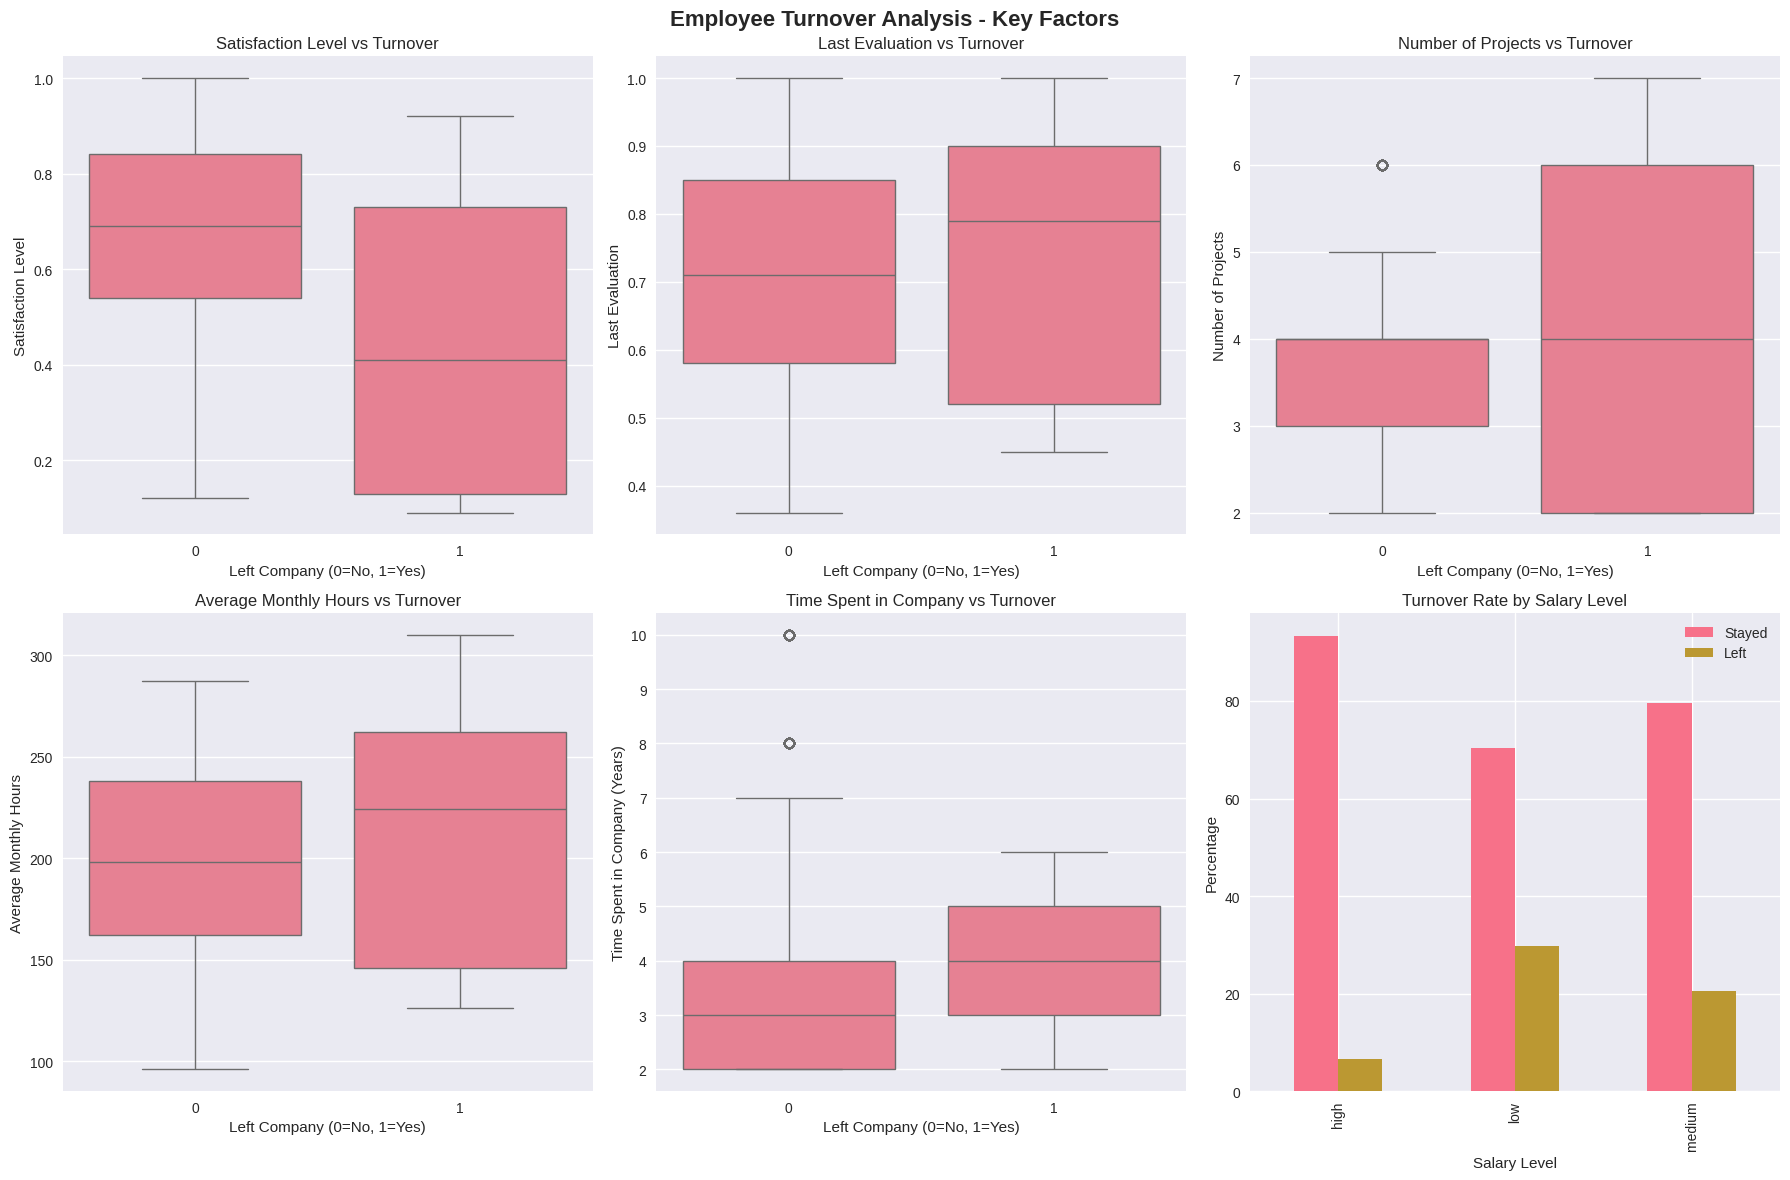


6. Correlation Analysis:


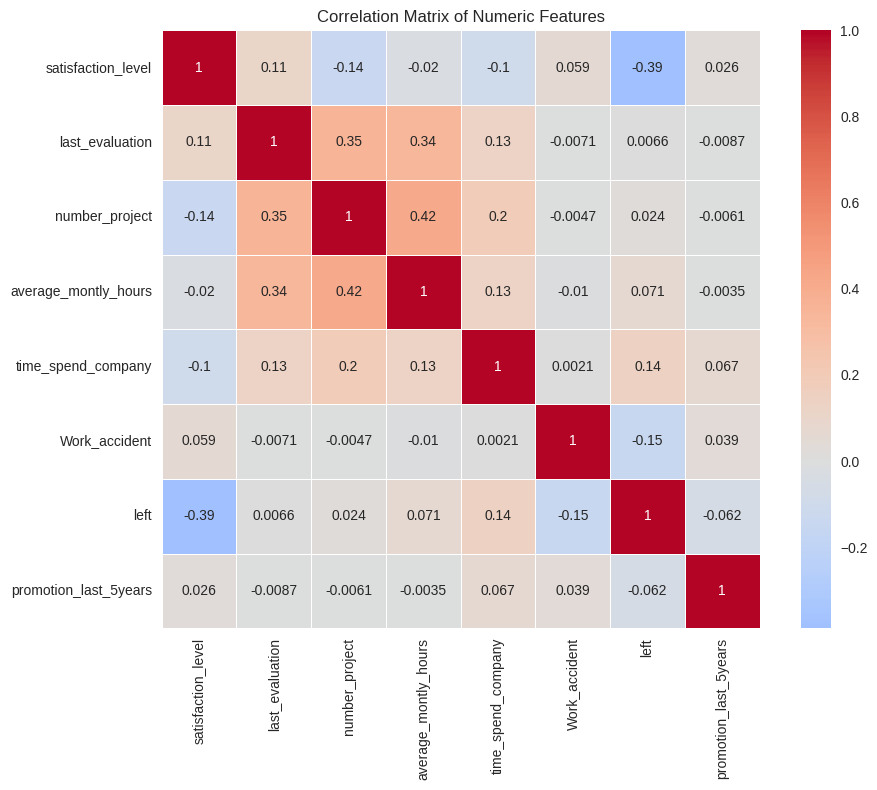


7. Key Insights from EDA:
----------------------------------------
Average satisfaction level for employees who left: 0.440
Average satisfaction level for employees who stayed: 0.667
Average monthly hours for employees who left: 207.4
Average monthly hours for employees who stayed: 199.1

Turnover rate by department:
  hr: 29.09%
  accounting: 26.60%
  technical: 25.62%
  support: 24.90%
  sales: 24.49%
  marketing: 23.66%
  IT: 22.25%
  product_mng: 21.95%
  RandD: 15.37%
  management: 14.44%

CLUSTERING ANALYSIS - EMPLOYEES WHO LEFT
Number of employees who left: 3571


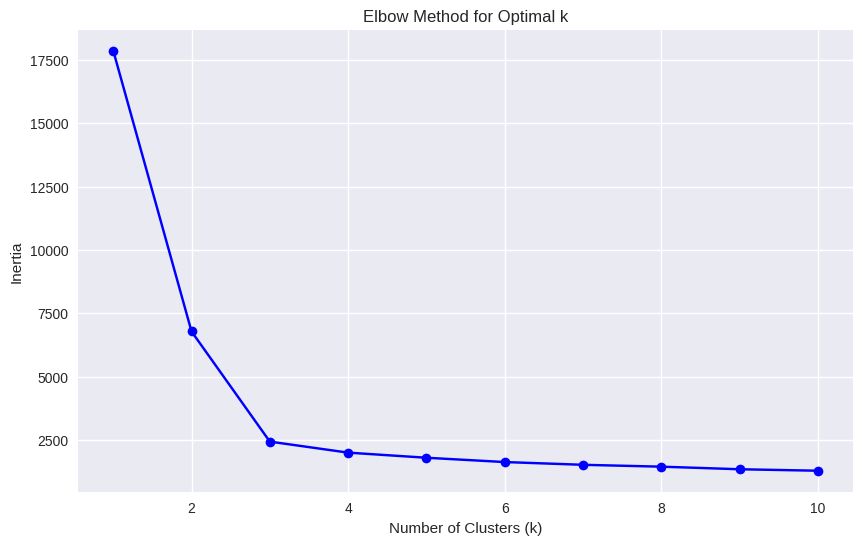

Optimal number of clusters: 3

Cluster Analysis:
----------------------------------------
         satisfaction_level  last_evaluation  number_project  \
cluster                                                        
0                  0.413875         0.522784        2.121892   
1                  0.119917         0.859948        6.152648   
2                  0.806705         0.911554        4.529718   

         average_montly_hours  time_spend_company  
cluster                                            
0                  148.565797            3.010916  
1                  273.143302            4.083074  
2                  242.619395            5.157456  


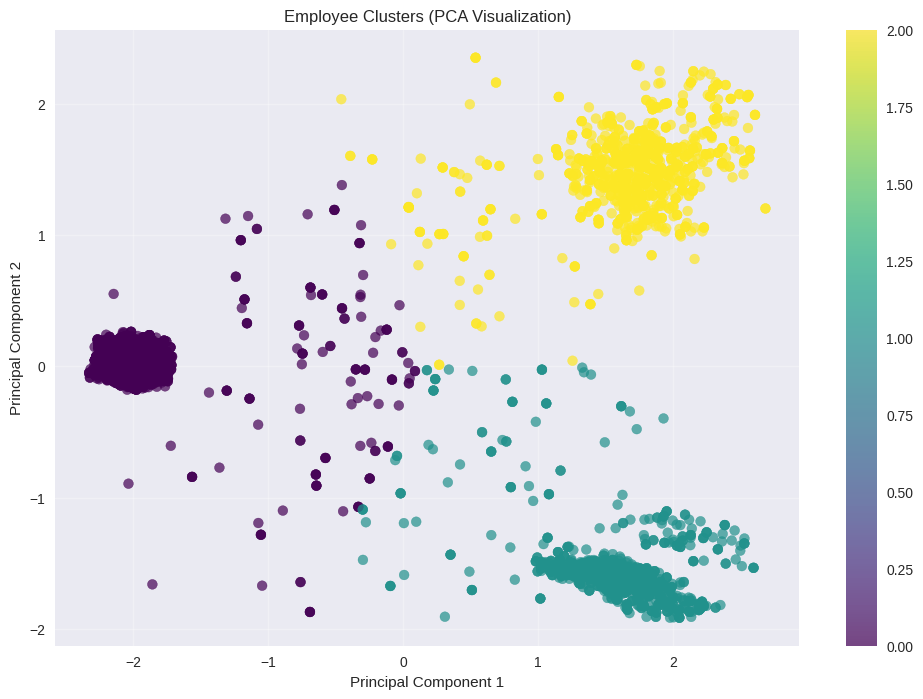


Cluster Profiles:
----------------------------------------

Cluster 0 (1649 employees):
  Average satisfaction: 0.414
  Average evaluation: 0.523
  Average projects: 2.1
  Average hours: 148.6
  Average tenure: 3.0 years

Cluster 1 (963 employees):
  Average satisfaction: 0.120
  Average evaluation: 0.860
  Average projects: 6.2
  Average hours: 273.1
  Average tenure: 4.1 years

Cluster 2 (959 employees):
  Average satisfaction: 0.807
  Average evaluation: 0.912
  Average projects: 4.5
  Average hours: 242.6
  Average tenure: 5.2 years

DATA PREPARATION FOR MODELING
Features shape: (14999, 9)
Target shape: (14999,)
Class distribution: {0: 11428, 1: 3571}
Training set shape: (11999, 9)
Test set shape: (3000, 9)

HANDLING CLASS IMBALANCE WITH SMOTE
Original training set class distribution:
left
0    9142
1    2857
Name: count, dtype: int64

Balanced training set class distribution:
left
0    9142
1    9142
Name: count, dtype: int64

MODEL TRAINING WITH K-FOLD CROSS-VALIDATION
Performin

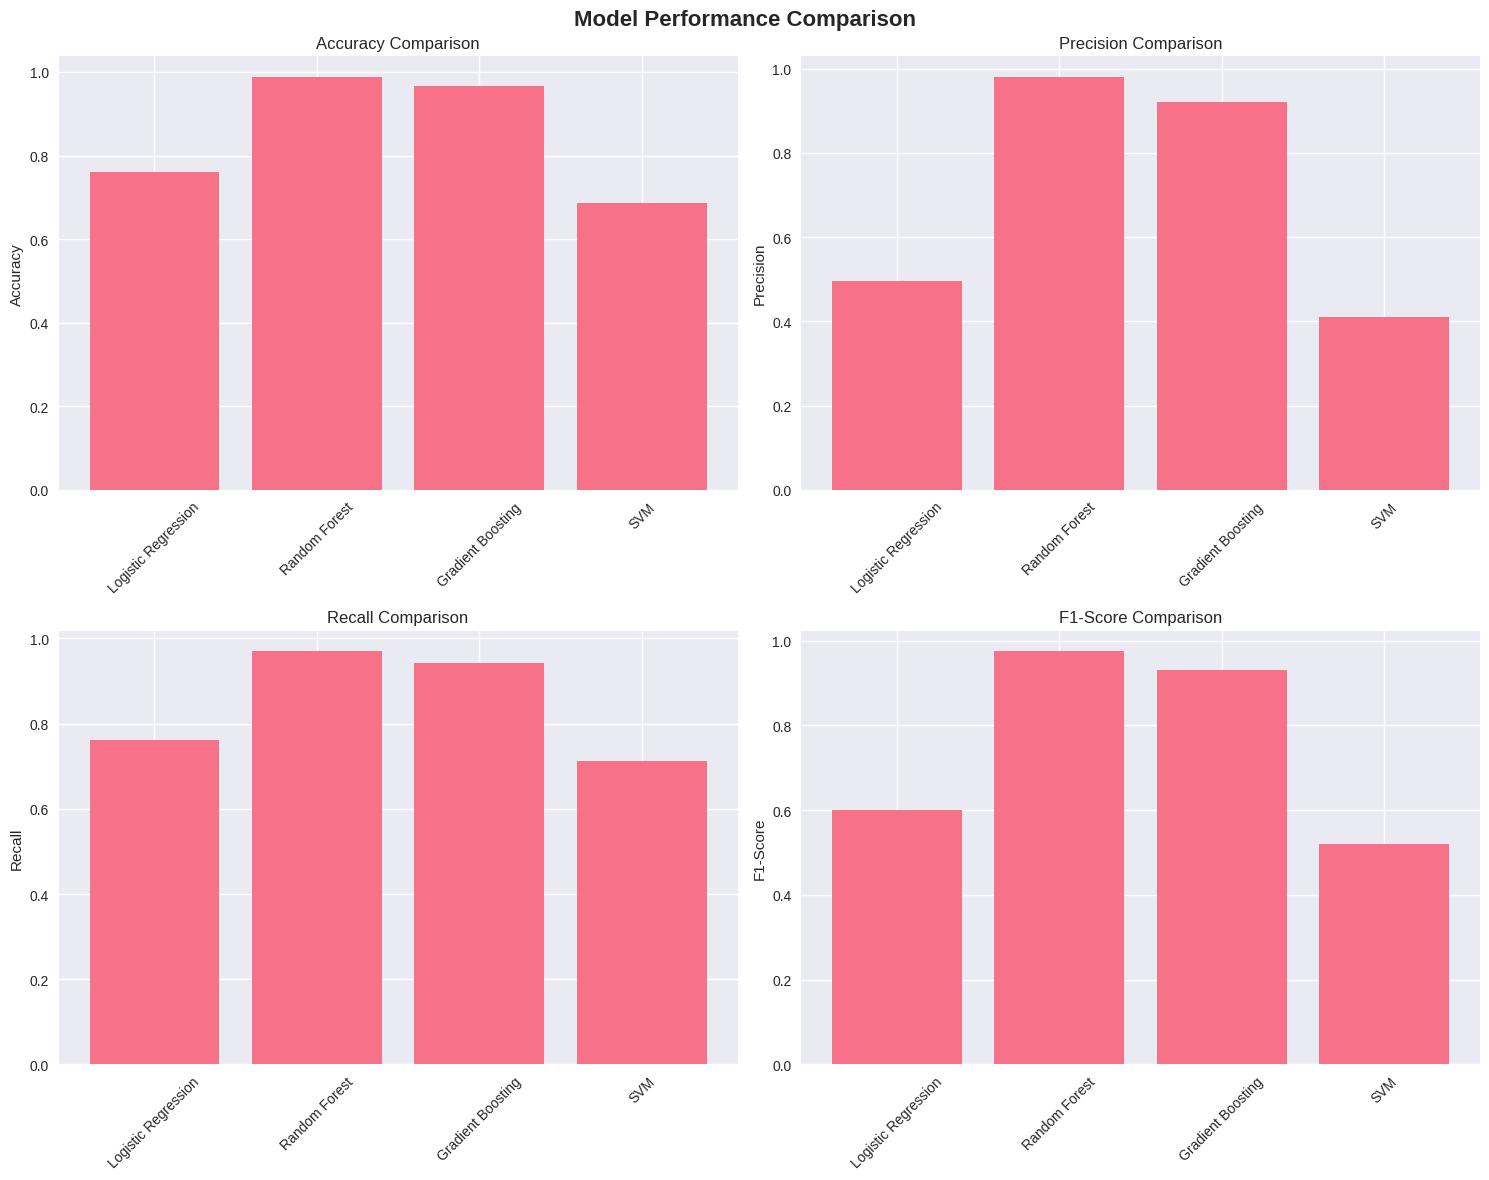


Best Model: Random Forest
F1-Score: 0.9746
Accuracy: 0.9880
Precision: 0.9802
Recall: 0.9692

Detailed Analysis of Random Forest:
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.97      0.97       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



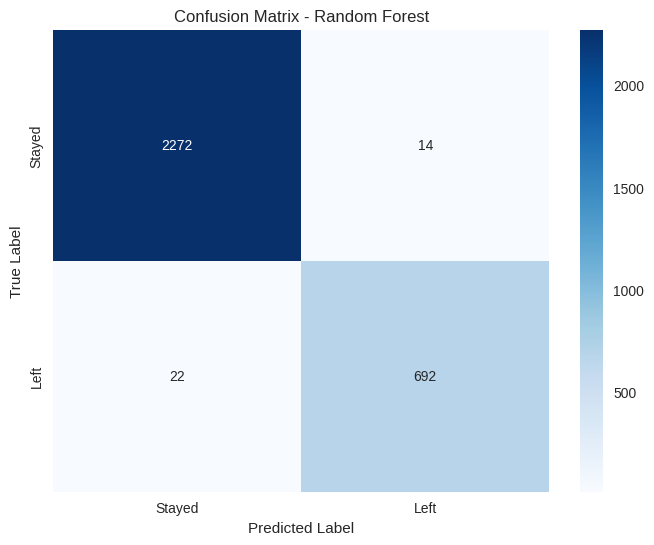

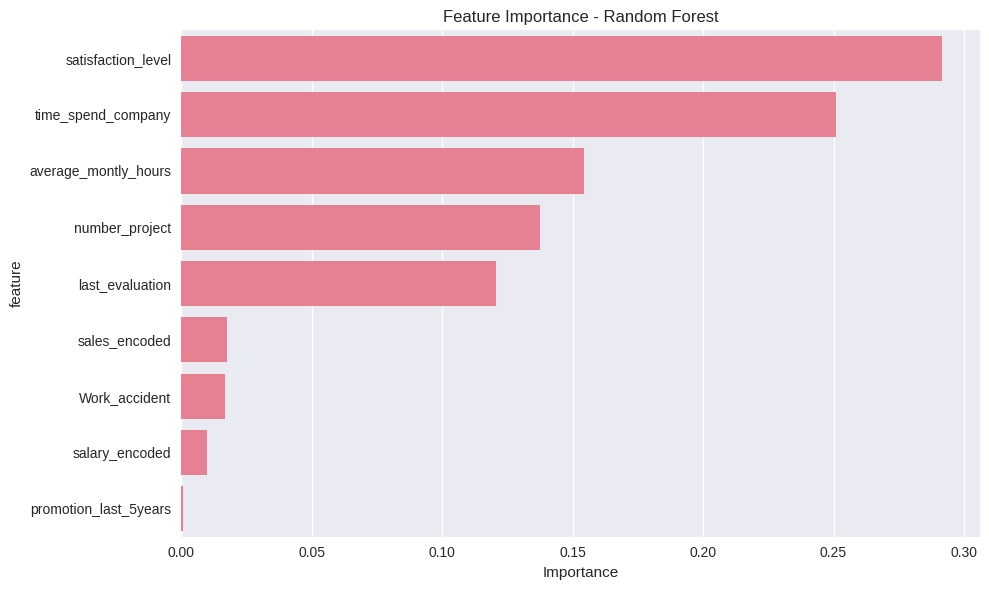


Top 5 Most Important Features:
                feature  importance
0    satisfaction_level    0.291548
4    time_spend_company    0.250954
3  average_montly_hours    0.154530
2        number_project    0.137645
1       last_evaluation    0.120633

RETENTION STRATEGY RECOMMENDATIONS
Number of high-risk current employees: 845

Targeted Retention Strategies:
--------------------------------------------------

Low Satisfaction Employees:
  Target Group: Employees with satisfaction level < 0.5
  Number of Employees: 2036
  Recommended Strategies:
    1. Conduct regular employee satisfaction surveys
    2. Implement flexible work arrangements
    3. Provide career development opportunities
    4. Improve work-life balance policies
    5. Enhance recognition and reward programs

Overworked Employees:
  Target Group: Employees working > 250 hours/month
  Number of Employees: 1960
  Recommended Strategies:
    1. Implement workload management systems
    2. Hire additional staff to reduce work

In [21]:
if __name__ == "__main__":
    main()